# Basic Example: Train a MOFA model

This notebook shows a simple way to train a MOFA$^1$ model with additional sparsity priors. We use a chronic lymphocytic leukaemia (CLL) data set, which combined ex vivo drug response measurements with somatic mutation status, transcriptome profiling and DNA methylation assays$^2$.

1: Multi-Omics Factor Analysis-a framework for unsupervised integration of multi-omics data sets by Argelaguet, R. et al. (2018)  
2: Drug-perturbation-based stratification of blood cancer by Dietrich et al. (2018) 

In [1]:
import numpy as np
import anndata as ad2
import muon as mu
import scanpy as sc
import pyro
import seaborn as sns
import matplotlib.pyplot as plt
import cellij

import torch

## Load CLL Data

In [2]:
mdata = cellij._data.Importer().load_CLL()

#### Preprocess data

In [3]:
# Normalize and log transform MRNA counts
sc.pp.normalize_total(mdata["mrna"], target_sum=1e4)
sc.pp.log1p(mdata["mrna"])

## Run Factor Analysis

In [11]:
# First we create an instance of a MOFA class
model = cellij.core.models.MOFA(n_factors=30, sparsity_prior=None)

In [12]:
# Afterwards, we need to add the data to the model
model.add_data(data=mdata)

In [13]:
# We call `.fit` to train the model
model.fit(
    likelihoods={
        "mrna": "Normal",
        "mutations": "Bernoulli",
        "drugs": "Normal",
        "methylation": "Normal",
    },
    epochs=10000,
    verbose_epochs=500,
    learning_rate=0.005,
    early_stopping=True,
    num_particles=10,
)

Training Model...
- Epoch      0 | Train Loss:         675.28 	
- Epoch    500 | Train Loss:         246.61 	| Decrease:  63.48%	| Time: 163.55s
- Epoch   1000 | Train Loss:         200.52 	| Decrease:  18.69%	| Time: 158.03s
- Epoch   1500 | Train Loss:         193.75 	| Decrease:   3.37%	| Time: 145.09s
- Epoch   2000 | Train Loss:         191.51 	| Decrease:   1.16%	| Time: 134.72s
- Epoch   2500 | Train Loss:         190.08 	| Decrease:   0.75%	| Time: 133.18s
- Epoch   3000 | Train Loss:         189.00 	| Decrease:   0.57%	| Time: 133.60s
- Epoch   3500 | Train Loss:         188.24 	| Decrease:   0.41%	| Time: 133.69s
- Epoch   4000 | Train Loss:         187.75 	| Decrease:   0.26%	| Time: 134.07s
- Epoch   4500 | Train Loss:         187.44 	| Decrease:   0.17%	| Time: 134.12s
- Epoch   5000 | Train Loss:         187.21 	| Decrease:   0.12%	| Time: 133.62s
- Epoch   5500 | Train Loss:         187.03 	| Decrease:   0.10%	| Time: 133.76s
Early stopping of training due to convergence

## Plot Results

After training, we can inspect all the learned parameters, visualize the loss curve, etc.

#### Plot ELBO during training 

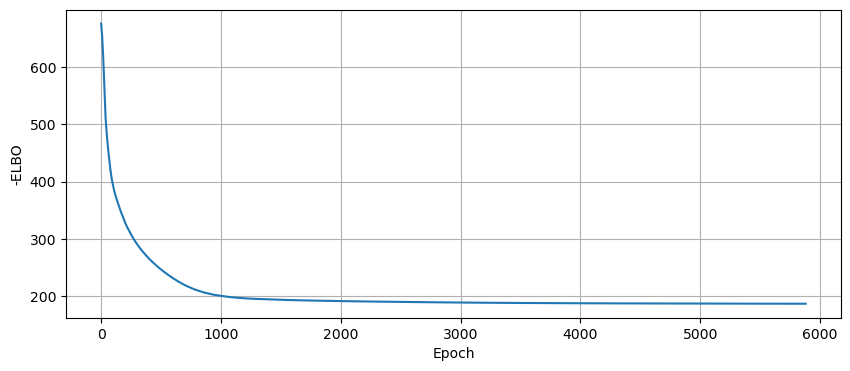

In [14]:
fig, ax = plt.subplots(1,1,figsize=(10,4))
plt.plot(model.train_loss_elbo)
plt.xlabel("Epoch")
plt.ylabel("-ELBO")
plt.grid(True)

#### Plot a heatmap of the weights and factors

The trained posteriors of weights and factors are accessible via `get_weights()` and `get_factors()` respectively.

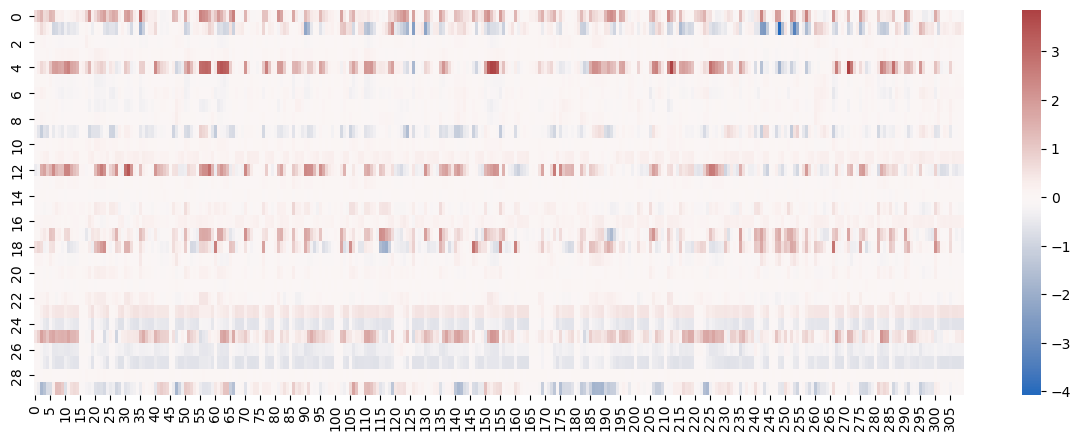

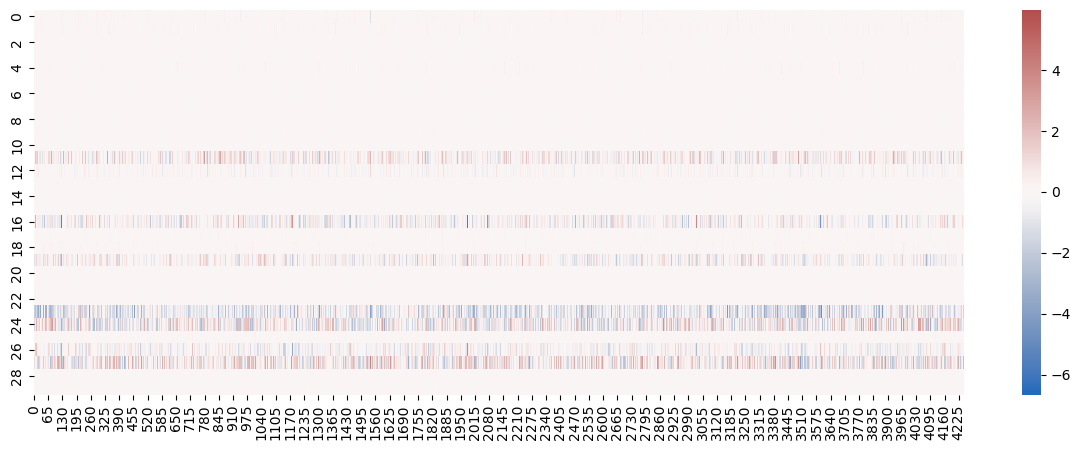

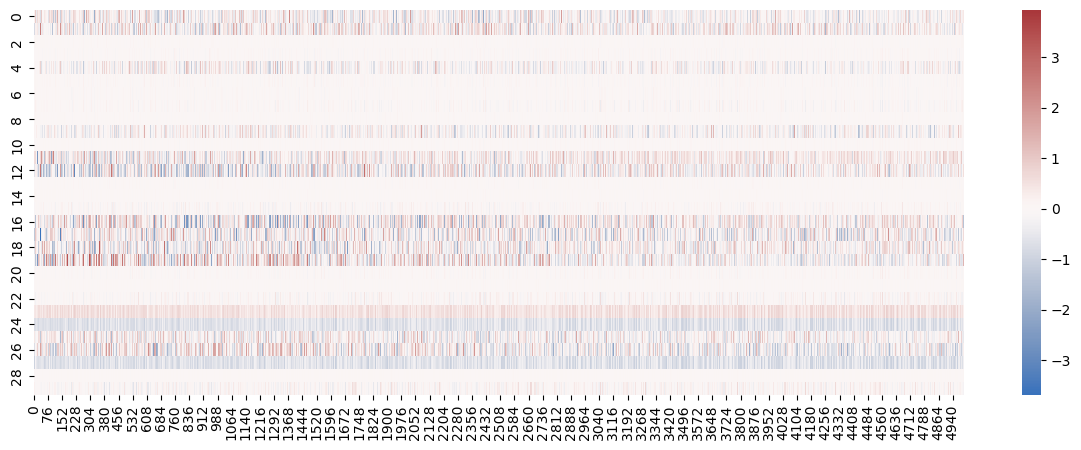

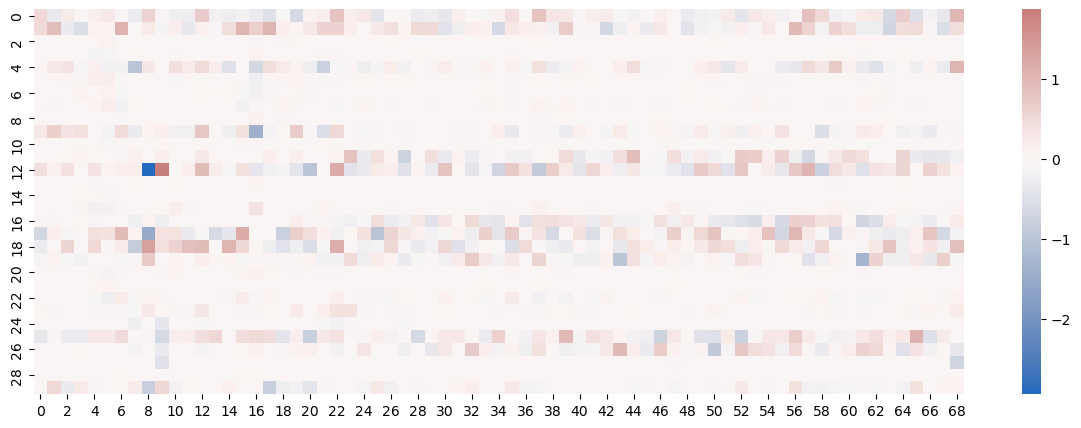

In [15]:
weights = model.get_weights(views="all")
for mod, w in weights.items():
    fig, ax = plt.subplots(1,1,figsize=(15,5))
    sns.heatmap(w, cmap="vlag", center=0)
    plt.show()